# Acoustics with variable coefficients

The hyperbolic system to be solved are the Acoustics equations with variable coefficients in 1D:
$$
\begin{aligned}
\partial_t p + K(x) \partial_x u &= 0 \\
\partial_t u + \frac{1}{\rho(x)} \partial_x p &= 0
\end{aligned}
$$
in $[\ell_b, u_b]\times[0,T]$,  with $p(x,0)=p_0(x)$, $u(x,0)=u_0(x)$.

We denote by $c(x)=\sqrt{\frac{K(x)}{\rho(x)}}$ the sound speed, and by $Z(x)=\rho(x) c(x)$ the impedance.

## Libraries and Dependencies

In [1]:
import sys
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):   #Subclassing torch's nn module
    def __init__(self, layers):
        super(DNN, self).__init__() #The same as super().__init__()
        
        #Parameters
        self.depth = len(layers) - 1
        
        # Activation function
        self.activation = torch.nn.Tanh

        # Set up layer order dictionary
        layerDict = OrderedDict()
        for i in range(self.depth - 1):
            layerDict[f"layer_{i}"] = torch.nn.Linear(layers[i], layers[i+1])
            layerDict[f"activation_{i}"] = self.activation()
        layerDict[f"layer_{self.depth-1}"] = torch.nn.Linear(layers[-2], layers[-1])
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

There are two loss functions:
- The mean squared error of the PDE residual (We use the automatic differentiation to compute the derivatives)
$$
\mathcal{L}_{\mathrm{f}} = \frac{1}{N_{\mathrm{f}}}\sum_{i=1}^{N_{\mathrm{f}}} f(x_i,t_i)= \frac{1}{N_{\mathrm{f}}}\sum_{i=1}^{N_{\mathrm{f}}} \left[\left|q_t+A(x)q_x \right|^2\right]_{x=x_i,t=t_i}
$$
- The mean squared error of the initial condition and boundary conditions
$$
\mathcal{L}_{\mathrm{u}} = \frac{1}{N_{\mathrm{u}}}\sum_{i=1}^{N_{\mathrm{u}}} \left( u(x_k,t_k) - u_k\right)^2,
$$ 
where $u_k$ is the known value of the solution at the $k$-th boundary point.

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub,interfaces, exact_bulk, exact_rho):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.interfaces = torch.tensor(interfaces).float().to(device)
        self.exact_bulk = torch.tensor(exact_bulk).float().to(device)
        self.exact_rho = torch.tensor(exact_rho).float().to(device)

        
        
        self.layers = layers

        #Instatiate parameters
        self.rhoL = torch.tensor([0.5], requires_grad=True).to(device)
        self.bulkL = torch.tensor([0.5], requires_grad=True).to(device)
        self.rhoR = torch.tensor([0.5], requires_grad=True).to(device)
        self.bulkR = torch.tensor([0.5], requires_grad=True).to(device)

        self.rhoL = torch.nn.Parameter(self.rhoL)
        self.bulkL = torch.nn.Parameter(self.bulkL)
        self.rhoR = torch.nn.Parameter(self.rhoR)
        self.bulkR = torch.nn.Parameter(self.bulkR)

        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        #Add parameters to DNN
        self.dnn.register_parameter('bulkL', self.bulkL)
        self.dnn.register_parameter('rhoL', self.rhoL)
        self.dnn.register_parameter('bulkR', self.bulkR)
        self.dnn.register_parameter('rhoR', self.rhoR)
        
        

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=1000, 
            max_eval=None,
            tolerance_grad=1e-5, 
            tolerance_change= 1e-9, #1.0 * np.finfo(float).eps,
            history_size=100,
            line_search_fn="strong_wolfe",      
        )

        self.iter = 0
        
    def net_u(self, x, t): 
        """ Here net_u represents the neural network approximation of the solution u""" 
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ Here net_f represents the residual function
        f(u) = q_t+A(x)q_x, where q = (rho,u) and A(x)q_x 
        where u is net_u, the neural network output, and the derivatives
        are calculated with automatic differentiation.
        """


        q = self.net_u(x, t) #q[:,0] contains pressure, q[:,1] contains velocity
       
        
        p_t = torch.autograd.grad(
            q[:,0], t,
            grad_outputs=torch.ones_like(q[:,0]),
            retain_graph=True,
            create_graph=True
        )[0]

        u_t = torch.autograd.grad(
            q[:,1], t,
            grad_outputs=torch.ones_like(q[:,1]),
            retain_graph=True,
            create_graph=True
        )[0]

        p_x = torch.autograd.grad(
             q[:,0], x, 
             grad_outputs=torch.ones_like(q[:,0]),
             retain_graph=True,
             create_graph=True
         )[0]
        
        u_x = torch.autograd.grad(
                q[:,1], x,
                grad_outputs=torch.ones_like(q[:,1]),
                retain_graph=True,
                create_graph=True
        )[0]

        rhoL = self.rhoL
        bulkL = self.bulkL

        rhoR = self.rhoR
        bulkR = self.bulkR

        Aq_x = torch.zeros(q.shape).to(device)

        Aq_x[:,0] = torch.where(x[:,0]<0, bulkL, bulkR)*u_x[:,0]
        Aq_x[:,1] = torch.where(x[:,0]<0, 1/rhoL, 1/rhoR)*p_x[:,0] 

    
        f = (1/(0.1*(abs(u_x)-u_x)+1))*(torch.cat([p_t, u_t], dim=1) + Aq_x)
        return f

    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = 10*loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5e}, Loss_u: {loss_u.item():.5e}, Loss_f: {loss_f.item():.5e}"
            )
        return loss
    
    def train(self):
        self.dnn.train()
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

PINN architecture

In [5]:
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 2]

Taking points from reference solution to enforce intial and boundary conditions. Since, for this problem, the PINN is not converging to the reference solution
even in the training points, we will also feed it some reference data from the interior of the domain.

In [6]:
#########################
# Retrieving unformatted data from CLAWPACK simulation
#########################
data = np.load("./data/Acoustics_data_CLAWPACK_forward_2_materials.npy", allow_pickle=True).item()
t = data['t'].flatten()[:,None] #Shape (n_t, 1)
x = data['x'].flatten()[:,None] #Shape (n_x, 1)
Exact = np.real(data['usol']) #shape is (n_t,2, n_x)

#Additional information from reference solution
exact_bulk = np.real(data['bulks']) #list of bulk modulus for each material
exact_rho = np.real(data['rhos']) #list of density for each material
interfaces = np.real(data['interfaces']) #List of interfaces between materials

###############
#Initial and boundary conditions
###############

X, T = np.meshgrid(x,t)
#X has shape (n_t, n_x)
#T has shape (n_t, n_x)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #All space-time points. Shape is (n_t*n_x, 2)
u1 = Exact[:,:,1].flatten()[:,None] #Momentum
u2 = Exact[:,:,0].flatten()[:,None] #Depth
u_star = np.hstack((u1, u2)) #Shape is (n_t*n_x, 2)

#################
#Getting intial and boundary data
#################
xt_initial = np.hstack((X[0:1,:].T, T[0:1,:].T)) # each row contains [x,t=0]
ref_sol_intial = Exact[0,:,:] # each row contains u(x,t=0) Shape is (n_x,2)

xt_lower_boundary = np.hstack((X[:,0:1], T[:,0:1])) # each row contains [x=-lb,t]
ref_sol_lower_boundary = Exact[:,0,:] # each row contains u(x=-1,t) Shape is (n_t,2)

xt_upper_boundary = np.hstack((X[:,-1:], T[:,-1:])) # each row contains [x=ub,t]
ref_sol_upper_boundary = Exact[:,-1,:] # each row contains u(x=1,t) Shape is (n_t,2)

#X_u_train = 
xt_IBCs= np.vstack([xt_initial, xt_lower_boundary, xt_upper_boundary])#shape (n_x + 2*n_t, 2)
#u_train =
ref_sol_IBCs = np.vstack([ref_sol_intial, ref_sol_lower_boundary, ref_sol_upper_boundary]) #shape (n_x + 2*n_t, 2)

#################
#Getting data from the interior
#################
N_data_times = 100
N_data_space = 100
xt_interior = np.zeros((N_data_times*N_data_space,2))
ref_sol_interior = np.zeros((N_data_times*N_data_space,2))
idxs_time = np.random.choice(t.shape[0], N_data_times, replace=False) #Choosing N_data_interior random points from the data to feed the NN
for i, idx_time in enumerate(idxs_time):
    idxs_space = np.random.choice(x.shape[0], N_data_space, replace=False)
    xt_interior[i*N_data_space:(i+1)*N_data_space,0] = x[idxs_space,0]
    xt_interior[i*N_data_space:(i+1)*N_data_space,1] = t[idx_time,0]
    ref_sol_interior[i*N_data_space:(i+1)*N_data_space,:] = Exact[idx_time,idxs_space,:]


##################
#From the interior and boundary points, we will choose a subset to be used as training data
##################
N_samples_IBCs = min(xt_IBCs.shape[0], 1000) #Number of points for initial and boundaries conditions to be taken from the reference solution
N_samples_interior = min(xt_interior.shape[0], 2000) #Number of points from interior to be taken from the reference solution

idx_IBCs = np.random.choice(xt_IBCs.shape[0], N_samples_IBCs, replace=False) #Choosing N_u random points from the (space and time) boundary 
idx_interior = np.random.choice(xt_interior.shape[0], N_samples_interior, replace=False) #Choosing N_u random points from the (space and time) boundary

xt_train_data = np.vstack((xt_IBCs[idx_IBCs,:], xt_interior[idx_interior,:])) #Adding the points where we will provide data
sol_train_data = np.vstack((ref_sol_IBCs[idx_IBCs,:], ref_sol_interior[idx_interior,:])) #Adding the points where we will provide data


Taking random points accross the domain to enforce the PDE residual. We also enforce the PDE residual at the points where we provide data.

In [7]:
# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)  
N_res = 10000 #Number of points for collocation 

#X_f_train =
xt_residual = lb + (ub-lb)*lhs(2, N_res) #Generating N_f random points in the domain
#xt_residual = np.vstack((xt_residual, xt_IBCs, xt_interior)) #Adding the points where we will provide data
xt_residual = np.vstack((xt_residual, xt_train_data)) #Adding the points where we will provide data

## Training

In [9]:
print(f"Checking shapes")
print(f"Shape of xt_train_data is {xt_train_data.shape}")
print(f"Shape of xt_residual is {xt_residual.shape}")
print(f"Shape of sol_train_data is {sol_train_data.shape}")

print(f"Other data")
print(f"Exact bulks are {exact_bulk}")
print(f"Exact rho are {exact_rho}")


model = PhysicsInformedNN(xt_train_data, sol_train_data, xt_residual, layers, lb, ub, interfaces, exact_bulk, exact_rho)

Checking shapes
Shape of xt_train_data is (3000, 2)
Shape of xt_residual is (13000, 2)
Shape of sol_train_data is (3000, 2)
Other data
Exact bulks are [1. 4.]
Exact rho are [1. 1.]


In [10]:
%%time

N_epochs = 4
for epoch in range(N_epochs):
    print(f'Epoch {epoch}') 
    model.train()
                 

Epoch 0
Iter 100, Loss: 5.71872e-02, Loss_u: 4.02957e-03, Loss_f: 1.68915e-02
Iter 200, Loss: 2.66478e-02, Loss_u: 2.30716e-03, Loss_f: 3.57621e-03
Iter 300, Loss: 1.53375e-02, Loss_u: 1.22673e-03, Loss_f: 3.07016e-03
Iter 400, Loss: 7.72555e-03, Loss_u: 4.91036e-04, Loss_f: 2.81519e-03
Iter 500, Loss: 3.49555e-03, Loss_u: 1.43523e-04, Loss_f: 2.06032e-03
Iter 600, Loss: 2.07532e-03, Loss_u: 6.47550e-05, Loss_f: 1.42777e-03
Iter 700, Loss: 1.69918e-03, Loss_u: 4.30423e-05, Loss_f: 1.26875e-03
Iter 800, Loss: 1.48374e-03, Loss_u: 3.58829e-05, Loss_f: 1.12491e-03
Iter 900, Loss: 1.21821e-03, Loss_u: 2.49747e-05, Loss_f: 9.68466e-04
Iter 1000, Loss: 1.03895e-03, Loss_u: 1.94196e-05, Loss_f: 8.44758e-04
Epoch 1
Iter 1100, Loss: 9.38147e-04, Loss_u: 1.74579e-05, Loss_f: 7.63568e-04
Iter 1200, Loss: 8.09544e-04, Loss_u: 1.49068e-05, Loss_f: 6.60475e-04
Iter 1300, Loss: 7.14835e-04, Loss_u: 1.20007e-05, Loss_f: 5.94828e-04
Iter 1400, Loss: 6.35175e-04, Loss_u: 9.46625e-06, Loss_f: 5.40512e-04

In [11]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))       

Error u: 7.440898e-01


In [21]:
rhoL_estimated = model.rhoL.detach().cpu().numpy()
bulkL_estimated = model.bulkL.detach().cpu().numpy()
rhoR_estimated = model.rhoR.detach().cpu().numpy()
bulkR_estimated = model.bulkR.detach().cpu().numpy()


print(f"rho estimated = {np.hstack((rhoL_estimated,rhoR_estimated))}")
print(f"rho exact = {exact_rho}")
print(f"bulk estimated = {np.hstack((bulkL_estimated,bulkR_estimated))}")
print(f"bulk exact = {exact_bulk}")

rho estimated = [1.001442  1.0026666]
rho exact = [1. 1.]
bulk estimated = [1.0004743 3.9951532]
bulk exact = [1. 4.]


## Visualizations

In [12]:
#Retrieving reference data and evaluating the model on a refined grid
x_test = data["x"]
t_test = data["t"]

extrapolation_time = np.linspace(30.,40.,50)

u_exact = []
u_frames = []
for j in range(len(t_test)):
   u_test, _ = model.predict(np.hstack((x_test.reshape(-1,1), t_test[j]*np.ones((len(x_test),1)))))
   u_frames.append(u_test)
   u_exact.append(data["usol"][j,:,:])

for k in range(1,len(extrapolation_time)):
   u_test, _ = model.predict(np.hstack((x_test.reshape(-1,1), extrapolation_time[k]*np.ones((len(x_test),1)))))
   u_frames.append(u_test)

### Static plot

In [13]:
list_training_idxs = []
u_predict_training = []
for time in t_test:
    t = time[0]
    list_training_idxs.append([i for i, training_t in enumerate(xt_train_data[:,1]) if abs(t - training_t) < 1.e-3])
    u_predict_training.append(model.predict(xt_train_data[list_training_idxs[-1]])[0])

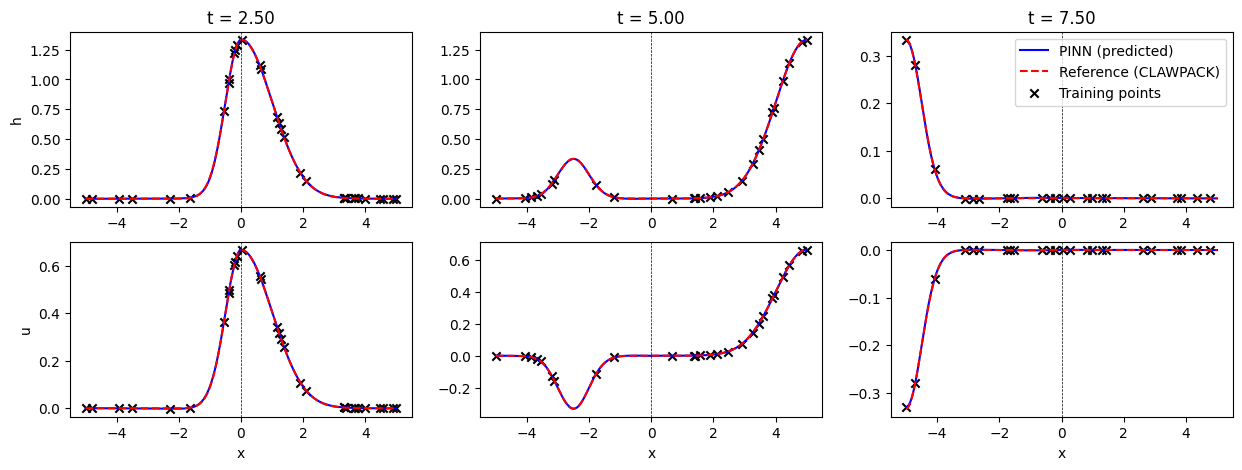

In [14]:
fig, ax = plt.subplots(2,3, figsize=(15,5))
for i in range(3):
    ax[0,i].plot(x_test, u_frames[25+i*25][:,0], 'b-', label='PINN (predicted)')
    ax[0,i].plot(x_test, u_exact[25+i*25][:,0], 'r--', label='Reference (CLAWPACK)')
    ax[0,i].scatter(xt_train_data[list_training_idxs[25+i*25],0], u_predict_training[25+i*25][:,0], color='black', marker='x', label='Training points')
    ax[0,i].set_title(f"t = {t_test[25+i*25][0]:.2f}")
    


    ax[1,i].plot(x_test, u_frames[25+i*25][:,1], 'b-')
    ax[1,i].plot(x_test, u_exact[25+i*25][:,1], 'r--')
    ax[1,i].scatter(xt_train_data[list_training_idxs[25+i*25],0], u_predict_training[25+i*25][:,1], color='black', marker='x')
    ax[1,i].set_xlabel('x')

    #Plot vertical lines to indicate the interface positions
    for interface in interfaces:
        ax[0,i].axvline(interface, color='black', linestyle='--',lw=0.5)
        ax[1,i].axvline(interface, color='black', linestyle='--',lw=0.5)

ax[0,0].set_ylabel('h')
ax[1,0].set_ylabel('u')
ax[0,-1].legend(loc='upper right')

### Animations (and testing genaralization)

In [15]:
list_training_idxs = []
u_predict_training = []
for time in t_test:
    t = time[0]
    list_training_idxs.append([i for i, training_t in enumerate(xt_train_data[:,1]) if abs(t - training_t) < 1.e-4])
    u_predict_training.append(model.predict(xt_train_data[list_training_idxs[-1]])[0])

In [16]:
def animation_function(x_test,t_test, u_frames, u_exact):
    from matplotlib import animation, rc
    from IPython.display import HTML

    fig, ax = plt.subplots(2,1,figsize=(8,5))
    ax[0].set_xlim(( min(x_test), max(x_test)))
    ax[0].set_ylim((-2.3, 2.3))
    ax[0].set_xlabel('$x$')

    ax[1].set_xlim(( min(x_test), max(x_test)))
    ax[1].set_ylim((-1.6, 1.2))
    ax[1].set_xlabel('$x$')
    
    ax[0].set_ylabel('$p(t,x)$ (pressure)')

    ax[1].set_ylabel('$u(t,x)$ (velocity)')
    original_title = f'1D Acoustics with variable impedance'
    ax[0].set_title(original_title)

    #Plot vertical lines to indicate the interface positions
    for interface in interfaces:
        ax[0].axvline(interface, color='black', linestyle='--',lw=0.5)
        ax[1].axvline(interface, color='black', linestyle='--',lw=0.5)
    
    line1, = ax[0].plot([], [], lw=2)
    line2, = ax[0].plot([], [], lw=2, color='black', linestyle='dotted')
    dots = ax[0].scatter([], [], s=20, c='g', marker='x')

    line3, = ax[1].plot([], [], lw=2, label='PINN')
    line4, = ax[1].plot([], [], lw=2, label='Reference (CLAWPACK)', color='black', linestyle='dotted')
    dots2 = ax[1].scatter([], [], s=20, label='Training ICs', c='g', marker='x')

    dotsPDEh = ax[0].scatter([], [], s=20, c='r', marker='o')
    dotsPDEhu = ax[1].scatter([], [], s=20, c='r', marker='o', label='Training PDEs')


    reduced_idx = np.array([i for i in idx_IBCs if i<xt_IBCs.shape[0]-1 ])

    
    #Initialization function
    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        dots.set_offsets(np.column_stack(([], [])))
        line3.set_data([], [])
        line4.set_data([], [])
        dots2.set_offsets(np.column_stack(([], [])))

        dotsPDEh.set_offsets(np.column_stack(([], [])))
        dotsPDEhu.set_offsets(np.column_stack(([], [])))

        return line1, line2, line3, line4, dots, dots2, dotsPDEh, dotsPDEhu

    #Animation function
    def animate(i):
        x = x_test
        if i<=len(u_exact)-1:
            line1.set_data(x, u_frames[i][:,0])
            line2.set_data(x, u_exact[i][:,0])
            line3.set_data(x, u_frames[i][:,1])#/u_frames[i][:,0])
            line4.set_data(x, u_exact[i][:,1])#/u_exact[i][:,0])
            if i==0:
                dots.set_offsets(np.column_stack((xt_IBCs[reduced_idx,0], ref_sol_IBCs[reduced_idx,0])))
                dots2.set_offsets(np.column_stack((xt_IBCs[reduced_idx,0], ref_sol_IBCs[reduced_idx,1])))#/uu1[reduced_idx,0,0])))
                dotsPDEh.set_offsets(np.column_stack(([], [])))
                dotsPDEhu.set_offsets(np.column_stack(([], [])))
            else:
                dots.set_offsets(np.column_stack(([], [])))
                dots2.set_offsets(np.column_stack(([], [])))
                dotsPDEh.set_offsets(np.column_stack((xt_train_data[list_training_idxs[i],0], u_predict_training[i][:,0])))
                dotsPDEhu.set_offsets(np.column_stack((xt_train_data[list_training_idxs[i],0],
                u_predict_training[i][:,1])))#/u_predict_training[i][:,0])))
        else:
            line1.set_color('r')
            line1.set_data(x, u_frames[i][:,0])
            line2.set_data([], [])
            line3.set_color('r')
            line3.set_data(x, u_frames[i][:,1])#/u_frames[i][:,0])
            line4.set_data([], [])
            dotsPDEh.set_offsets(np.column_stack(([], [])))
            dotsPDEhu.set_offsets(np.column_stack(([], [])))

        return line1, line2, dots, line3, line4, dots2, dotsPDEh, dotsPDEhu
    #Call the animator
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                    frames=len(u_frames), interval=60, blit=True)
    ax[1].legend(loc='lower right')
    plt.close()
    #plot the animation
    return HTML(anim.to_jshtml())

In [17]:
plot = animation_function(x_test,t_test,u_frames, u_exact)

Once the PINN line becomes red, we are extrapolating in time.
Training ICs denotes the PINN evaluated at points that where used to enforce the initial condition.
Training PDE denotes the PINN evaluated at points that where used to enforce the PDE.

In [18]:
plot